<a href="https://colab.research.google.com/github/ehdrn463/dataanalysis_capstone/blob/master/0430_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd # 데이터 전처리
import numpy as np # 데이터 전처리
import random #데이터 전처리
from pandas import DataFrame #데이터 전처리
from collections import Counter #데이터 전처리

from tqdm import tqdm #시간 측정용

from sklearn.feature_extraction.text import CountVectorizer # model setting
from sklearn.model_selection import train_test_split  # model setting

from sklearn.naive_bayes import MultinomialNB  # model 관련
from sklearn.metrics import roc_auc_score  # model 성능 확인

import re
from tqdm import tqdm_notebook
import os

In [0]:
# DTM 문서 단어 행렬
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer()

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer    
tfvector = TfidfTransformer(smooth_idf=False)

In [0]:
vectorizer=TfidfVectorizer(ngram_range=(1, 3),
    min_df=2,       
    max_features=10000,
    sublinear_tf=True,
    lowercase=False,
    use_idf=True)

# Directory 변경


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

ValueError: ignored

In [0]:
# from konlpy.tag import Mecab
# mecab = Mecab()

/


In [0]:
ls

gdrive/  sample_data/


In [0]:
cd gdrive/My\ Drive/kb_data

/content/gdrive/My Drive/kb_data


In [0]:
prepared_train = pd.read_csv('prepared_train.csv', encoding='utf-8')

In [0]:
del prepared_train['Unnamed: 0']

In [0]:
%%time
vec_train = vectorizer.fit_transform(prepared_train['orgin'])

CPU times: user 48.8 s, sys: 1.46 s, total: 50.3 s
Wall time: 50.3 s


# LightGBM 모델링


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import lightgbm
import joblib

In [0]:
#X_train = prepared_train.drop(['year_month', 'text', 'morph', 'orgin', 'smishing'], axis='columns')
X_origin = vec_train
Y_label = prepared_train['smishing']

In [0]:
# train - test 분류
# 인덱싱 문제로 순서대로 train / test split
%%time
X_train, X_test, Y_train, Y_test = train_test_split(X_origin,
                                                    Y_label,
                                                    test_size = 0.2,
                                                    shuffle = False)
                                                    # random_state = 1825)

CPU times: user 45.5 ms, sys: 0 ns, total: 45.5 ms
Wall time: 45.3 ms


In [0]:
# 4FOLD, 3SEED ENSEMBLE
# 총 12개의 모델을 평균내어 예측한다
%%time
#lucky_seed=[1996, 8, 25]
lucky_seed = [5, 8 , 10]

# enumerate: 인덱스와 값을 둘다 반복시킬 때 사용
for num,rs in tqdm(enumerate(lucky_seed)):


    kfold = KFold(n_splits=4, random_state = rs, shuffle = True)

    # numpy.zeros((row,col))
    # row*col size 영행렬 생성
    # train.shape[0],198 -> trainset 41400개, target값:198개
    cv=np.zeros((X_train.shape[0],2))

    for n, (train_idx, validation_idx) in tqdm(enumerate(kfold.split(X_train))):
        print(train_idx, validation_idx)
        x_train, x_validation = X_train[train_idx], X_train[validation_idx]
        y_train, y_validation = Y_train.loc[train_idx], Y_train.loc[validation_idx]

        lgbm = LGBMClassifier(n_estimators=380,
                     learning_rate=0.035,
                     max_depth=7,
                     min_child_samples=50,
                     random_state=4321)
        
        lgbm.fit(x_train, y_train, eval_set=[(x_validation, y_validation)], early_stopping_rounds= 30, verbose=100) 

        # 모델결과 저장 lib
        joblib.dump(lgbm, 'models/%s_fold_model_%s.pkl'%(n,rs))

        # numpy.zeros((row,col))로 만들어주었던 영행렬: cv
        # data object에 X_validation 예측 값을 넣어줌
        # CROSS-VALIDATION , EVALUATE CV
        cv[validation_idx,:] = lgbm.predict_proba(x_validation)
        



0it [00:00, ?it/s]


0it [00:00, ?it/s]

[     0      1      2 ... 236753 236754 236755] [     3      4     13 ... 236732 236735 236751]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00425152
[200]	valid_0's binary_logloss: 0.000904433
[300]	valid_0's binary_logloss: 0.000541626
Did not meet early stopping. Best iteration is:
[380]	valid_0's binary_logloss: 0.000435982





1it [01:29, 89.76s/it]

[     0      1      2 ... 236751 236752 236754] [    12     14     27 ... 236748 236753 236755]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00439705
[200]	valid_0's binary_logloss: 0.0011436
[300]	valid_0's binary_logloss: 0.000804013
Did not meet early stopping. Best iteration is:
[379]	valid_0's binary_logloss: 0.000755107





2it [02:58, 89.49s/it]

[     0      2      3 ... 236753 236754 236755] [     1      5      7 ... 236744 236745 236750]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00391277
[200]	valid_0's binary_logloss: 0.000723647
[300]	valid_0's binary_logloss: 0.000436902
Did not meet early stopping. Best iteration is:
[378]	valid_0's binary_logloss: 0.00038919





3it [04:27, 89.26s/it]

[     1      3      4 ... 236751 236753 236755] [     0      2      6 ... 236749 236752 236754]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00476046
[200]	valid_0's binary_logloss: 0.00156853
[300]	valid_0's binary_logloss: 0.00126015
Did not meet early stopping. Best iteration is:
[379]	valid_0's binary_logloss: 0.00120957





4it [05:56, 89.13s/it]


1it [05:56, 356.54s/it]


0it [00:00, ?it/s]

[     2      3      5 ... 236752 236754 236755] [     0      1      4 ... 236748 236751 236753]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00421
[200]	valid_0's binary_logloss: 0.00111194
[300]	valid_0's binary_logloss: 0.000820891
Did not meet early stopping. Best iteration is:
[369]	valid_0's binary_logloss: 0.000779575





1it [01:30, 90.69s/it]

[     0      1      3 ... 236751 236753 236754] [     2      9     10 ... 236745 236752 236755]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00396629
[200]	valid_0's binary_logloss: 0.000816632
[300]	valid_0's binary_logloss: 0.000489608
Did not meet early stopping. Best iteration is:
[380]	valid_0's binary_logloss: 0.00041545





2it [03:00, 90.31s/it]

[     0      1      2 ... 236752 236753 236755] [     3      5     14 ... 236749 236750 236754]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00433441
[200]	valid_0's binary_logloss: 0.00109567
[300]	valid_0's binary_logloss: 0.000767643
Did not meet early stopping. Best iteration is:
[377]	valid_0's binary_logloss: 0.000720704





3it [04:28, 89.73s/it]

[     0      1      2 ... 236753 236754 236755] [     6      8     13 ... 236741 236742 236747]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00476024
[200]	valid_0's binary_logloss: 0.00151443
[300]	valid_0's binary_logloss: 0.00118248
Did not meet early stopping. Best iteration is:
[380]	valid_0's binary_logloss: 0.0011207





4it [05:57, 89.29s/it]


2it [11:53, 356.72s/it]


0it [00:00, ?it/s]

[     2      4      6 ... 236752 236753 236754] [     0      1      3 ... 236742 236747 236755]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00425928
[200]	valid_0's binary_logloss: 0.00104061
[300]	valid_0's binary_logloss: 0.000716262
Did not meet early stopping. Best iteration is:
[380]	valid_0's binary_logloss: 0.000633458





1it [01:29, 89.58s/it]

[     0      1      2 ... 236751 236752 236755] [     4     11     14 ... 236744 236753 236754]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.004189
[200]	valid_0's binary_logloss: 0.000930921
[300]	valid_0's binary_logloss: 0.000586358
Did not meet early stopping. Best iteration is:
[380]	valid_0's binary_logloss: 0.000529254





2it [02:58, 89.50s/it]

[     0      1      2 ... 236753 236754 236755] [     6      7      9 ... 236750 236751 236752]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00464378
[200]	valid_0's binary_logloss: 0.00122242
[300]	valid_0's binary_logloss: 0.000793067
Did not meet early stopping. Best iteration is:
[380]	valid_0's binary_logloss: 0.000704476





3it [04:27, 89.24s/it]

[     0      1      3 ... 236753 236754 236755] [     2     10     12 ... 236733 236736 236740]
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.00448373
[200]	valid_0's binary_logloss: 0.00126232
[300]	valid_0's binary_logloss: 0.00103876
Early stopping, best iteration is:
[343]	valid_0's binary_logloss: 0.00103236





4it [05:54, 88.70s/it]


3it [17:48, 356.16s/it]


In [0]:
# MODEL LOAD & TEST PREDICT
# 12 MODELS 평균 사용
models = os.listdir('models/')
models_list = [x for x in models if x.endswith(".pkl")]

# 모델결과가 잘 나왔는지 check
# assert: 좌항과 우항의 값이 같으면 정상 작동, 다르면 오류 발생
assert len(models_list) ==12


temp_predictions = np.zeros((X_test.shape[0],2))

# 12개 모델을 반복시켜서 결과산출 -> 12로 나눠서 평균값 계산
for model in models_list:
    model = joblib.load('models/'+model)
    predict_proba = model.predict_proba(X_test)
    temp_predictions += predict_proba/12

In [0]:
# dacon code
submission = pd.DataFrame(data=np.zeros((X_test.shape[0],2)))
submission.index = Y_test.index 
submission.index.name = 'id'
submission+=temp_predictions

submission = submission.sort_index()
submission = submission.groupby('id').mean()
submission.to_csv('submission.csv', index=True)

In [0]:
submission['pred'] = 0

In [0]:
for idx in submission.index:
    if (submission[0][idx] < submission[1][idx]):
        submission['pred'][idx]= 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
submission

,0,1,pred
id,,,
236756,0.999994,0.000006,0
236757,0.999994,0.000006,0
236758,0.999994,0.000006,0
236759,0.999994,0.000006,0
236760,0.999995,0.000005,0
...,...,...,...
295940,0.999995,0.000005,0
295941,0.999994,0.000006,0
295942,0.999911,0.000089,0


In [0]:
from sklearn.metrics import classification_report

In [0]:
result = classification_report(Y_test, submission['pred'], target_names=['normal','smishing'])

In [0]:
print(result)

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     51205
    smishing       1.00      0.97      0.99      7984

    accuracy                           1.00     59189
   macro avg       1.00      0.99      0.99     59189
weighted avg       1.00      1.00      1.00     59189



In [0]:
from sklearn.metrics import accuracy_score

In [0]:
accuracy_score(Y_test, submission['pred'])

0.9961310378617648

In [0]:
accuracy_score(Y_test, submission['pred'], normalize=False)

58960

In [0]:
len(Y_test)

59189

# Support Vector Machine


In [0]:
from sklearn import svm

In [0]:
%%time
# 4FOLD, 3SEED ENSEMBLE
# 총 12개의 모델을 평균내어 예측한다

#lucky_seed=[1996, 8, 25]
lucky_seed = [5, 8 , 10]

# enumerate: 인덱스와 값을 둘다 반복시킬 때 사용
for num,rs in tqdm(enumerate(lucky_seed)):


    kfold = KFold(n_splits=4, random_state = rs, shuffle = True)

    # numpy.zeros((row,col))
    # row*col size 영행렬 생성
    # train.shape[0],198 -> trainset 41400개, target값:198개
    cv=np.zeros((X_train.shape[0],2))

    for n, (train_idx, validation_idx) in tqdm(enumerate(kfold.split(X_train))):
        
        x_train, x_validation = X_train[train_idx], X_train[validation_idx]
        y_train, y_validation = Y_train.loc[train_idx], Y_train.loc[validation_idx]

        svm_model = svm.SVC(kernel='linear',
                            class_weight='balanced',
                            random_state=4321)
        
        svm_model.fit(x_train, y_train) 

        # 모델결과 저장 lib
        joblib.dump(svm_model, 'svm_models/%s_fold_model_%s.pkl'%(n,rs))

        # numpy.zeros((row,col))로 만들어주었던 영행렬: cv
        # data object에 X_validation 예측 값을 넣어줌
        # CROSS-VALIDATION , EVALUATE CV
        cv[validation_idx,:] = svm_model.predict_proba(x_validation)
        

0it [00:00, ?it/s]
0it [00:00, ?it/s]

AttributeError: ignored

### 위 모델 안되는 이유
: https://stackoverflow.com/questions/43036711/scikit-learn-svc-predict-probability-doesnt-work-as-expected

In [0]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

In [0]:
%%time
# 4FOLD, 3SEED ENSEMBLE
# 총 12개의 모델을 평균내어 예측한다

#lucky_seed=[1996, 8, 25]
lucky_seed = [5, 8 , 10]

# enumerate: 인덱스와 값을 둘다 반복시킬 때 사용
for num,rs in tqdm(enumerate(lucky_seed)):


    kfold = KFold(n_splits=4, random_state = rs, shuffle = True)

    # numpy.zeros((row,col))
    # row*col size 영행렬 생성
    # train.shape[0],198 -> trainset 41400개, target값:198개
    cv=np.zeros((X_train.shape[0],2))

    for n, (train_idx, validation_idx) in tqdm(enumerate(kfold.split(X_train))):
        
        x_train, x_validation = X_train[train_idx], X_train[validation_idx]
        y_train, y_validation = Y_train.loc[train_idx], Y_train.loc[validation_idx]
        
        model_svc = LinearSVC(class_weight='balanced',
                              random_state=4321)
        
        svm_model = CalibratedClassifierCV(model_svc)

        svm_model.fit(x_train, y_train) 

        # 모델결과 저장 lib
        joblib.dump(svm_model, 'svm_models/%s_fold_model_%s.pkl'%(n,rs))

        # numpy.zeros((row,col))로 만들어주었던 영행렬: cv
        # data object에 X_validation 예측 값을 넣어줌
        # CROSS-VALIDATION , EVALUATE CV
        cv[validation_idx,:] = svm_model.predict_proba(x_validation)
        



0it [00:00, ?it/s]


0it [00:00, ?it/s]


1it [00:05,  5.04s/it]


2it [00:10,  5.02s/it]


3it [00:15,  5.07s/it]


4it [00:20,  5.09s/it]


1it [00:20, 20.38s/it]


0it [00:00, ?it/s]


1it [00:05,  5.02s/it]


2it [00:10,  5.03s/it]


3it [00:15,  5.00s/it]


4it [00:19,  4.92s/it]


2it [00:40, 20.17s/it]


0it [00:00, ?it/s]


1it [00:05,  5.34s/it]


2it [00:10,  5.27s/it]


3it [00:15,  5.16s/it]


4it [00:20,  5.10s/it]


3it [01:00, 20.16s/it]

CPU times: user 1min 7s, sys: 38 s, total: 1min 45s
Wall time: 1min


In [0]:
# MODEL LOAD & TEST PREDICT
# 12 MODELS 평균 사용
models = os.listdir('svm_models/')
models_list = [x for x in models if x.endswith(".pkl")]

# 모델결과가 잘 나왔는지 check
# assert: 좌항과 우항의 값이 같으면 정상 작동, 다르면 오류 발생
assert len(models_list) ==12


temp_predictions = np.zeros((X_test.shape[0],2))

# 12개 모델을 반복시켜서 결과산출 -> 12로 나눠서 평균값 계산
for model in models_list:
    model = joblib.load('svm_models/'+model)
    predict_proba = model.predict_proba(X_test)
    temp_predictions += predict_proba/12

In [0]:
# dacon code
submission = pd.DataFrame(data=np.zeros((X_test.shape[0],2)))
submission.index = Y_test.index 
submission.index.name = 'id'
submission+=temp_predictions

submission = submission.sort_index()
submission = submission.groupby('id').mean()
submission.to_csv('svm_submission.csv', index=True)

In [0]:
submission

,0,1
id,,
236756,0.999995,0.000005
236757,0.999933,0.000067
236758,0.999804,0.000196
236759,0.999976,0.000024
236760,0.999975,0.000025
...,...,...
295940,0.999944,0.000056
295941,0.999291,0.000709
295942,0.999951,0.000049


In [0]:
submission['pred'] = 0

In [0]:
for idx in submission.index:
    if (submission[0][idx] < submission[1][idx]):
        submission['pred'][idx]= 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
submission

,0,1,pred
id,,,
236756,0.999995,0.000005,0
236757,0.999933,0.000067,0
236758,0.999804,0.000196,0
236759,0.999976,0.000024,0
236760,0.999975,0.000025,0
...,...,...,...
295940,0.999944,0.000056,0
295941,0.999291,0.000709,0
295942,0.999951,0.000049,0


In [0]:
from sklearn.metrics import classification_report

In [0]:
result = classification_report(Y_test, submission['pred'], target_names=['normal','smishing'])

In [0]:
print(result)

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     51205
    smishing       1.00      0.98      0.99      7984

    accuracy                           1.00     59189
   macro avg       1.00      0.99      0.99     59189
weighted avg       1.00      1.00      1.00     59189



In [0]:
from sklearn.metrics import accuracy_score

In [0]:
accuracy_score(Y_test, submission['pred'])

0.9974319552619575

In [0]:
accuracy_score(Y_test, submission['pred'], normalize=False)

59037

In [0]:
len(Y_test)

59189

In [0]:
import matplotlib.pylab as plt
import scipy.sparse as sparse

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ValueError: ignored

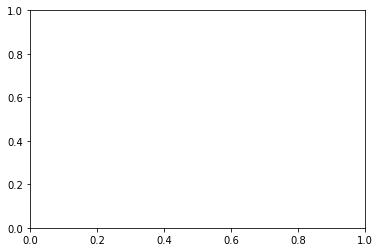

In [0]:
plt.spy(x_train, y_train)

In [0]:
sparse.spmatrix(x_train)

ValueError: ignored

In [0]:
type(x_train)

scipy.sparse.csr.csr_matrix

In [0]:
pip install betterspy

     |████████████████████████████████| 153kB 4.1MB/s 
  Created wheel for purepng: filename=purepng-0.2.0-cp36-cp36m-linux_x86_64.whl size=349371 sha256=55371bd111cf84eedb4a2a6cbd9bc918824497a9be9adfabc5dbdda4ab80b91c
  Stored in directory: /root/.cache/pip/wheels/c3/1c/f3/f27382debc5b947c2239743b3e82cb9e6aeed3942377a07ae3
Successfully built purepng


In [0]:
import betterspy

In [0]:
betterspy.show(x_train)

DecompressionBombError: ignored

# Imbalanced data 개선
1. Over Sampling
2. Under Sampling
3. Combining Over and Under Sampling

## 1. Over Sampling

## 2. Under Sampling

## 3. Combining Over and Under Sampling